In [1]:
"""
A collection of functions to perform a dark photon search on an averaged spectrum


Functions
-------
median_filt(
    
):
    LPF for spectrum. Recomended as a pre-filter if
    spec contains large, very narrow candidates

butter_filt(

):
    LPF for spectrum. 

SG_filt(

):
    LPF for spectrum

match_filt(
    
):
    Performs a matched filtering on approx. normally distributed data
    Internal helper functions include freq2idx and genNuSteps

set_limit(

):
    Sets a limit (or series of limits) on an array of 
    normally distributed data (or list of arrays of normal data)

get_required_sigma(

):
    Given a number of samples and a desired confidence limit, tells you how 
    many "N" sigma you need to go to in order to be CL% confident no samples
    are above the calculated "N" 
"""
import numpy as np 
import scipy.signal as spsig
import scipy.ndimage as spim
import cupyx.scipy.ndimage as cpim
import cupy as cp
from scipy.signal import butter, filtfilt
import scipy.stats
import scipy.special
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib widget


def median_filt(spec, filter_size=50, gpuFlag = 1):
    """
    Function to apply median filtering to a spectrum.

    Parameters
    ----------
    spectrum : array
        The input power spectrum.

    filter_size : int, optional
        Size of the median filter. Default is 50.

    Returns
    -------
    spectrum_filtered : array
        The median-filtered spectrum.
    """
    if gpuFlag:
        spectrum_gpu = cp.array(spec)
        spectrum_filtered_gpu = cpim.median_filter(
            spectrum_gpu,
            size=(filter_size),
            origin=0
        )
        spectrum_filtered = spectrum_filtered_gpu.get()
    else:
        spectrum_filtered = spim.median_filter(
            spec,
            size=(filter_size),
            origin=0
        )
    return spectrum_filtered

def butter_filt(spec, cutoff=40000, order=6):
    """
    Function to apply Butterworth low-pass filtering to a spectrum.

    Parameters
    ----------
    spectrum : array
        The input power spectrum.

    cutoff : int, optional
        Cutoff frequency for the filter. Default is 40000.

    order : int, optional
        Order of the filter. Default is 6.

    Returns
    -------
    spectrum_filtered : array
        The Butterworth low-pass filtered spectrum.
    """
    nyq = 0.5 * len(spec)  # Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    spectrum_filtered = filtfilt(b, a, spec)
    return spectrum_filtered

def sg_filt(spec, window_length=51, polyorder=4):
    """
    Apply a Savitzky-Golay filter to the spectrum.

    Parameters
    ----------
    window_length : int, optional
        Length of the filter window; must be a positive odd integer, default is 51.
    polyorder : int, optional
        Order of the polynomial used to fit the samples, default is 1.

    Returns
    -------
    arr
        Filtered spectrum.
    """
    spectrum_filtered = spsig.savgol_filter(spec, window_length=window_length, polyorder=polyorder)
    return spectrum_filtered

def matched_filt(freqs, 
    spec, 
    startFreq, 
    stopFreq, 
    percent, 
    overlap
    ):
    """
    Apply a matched filter to the input spectrum over a specified frequency range.

    This function divides the freqs range into steps and applies a convolution
    operation with a lambda template for each step. The function returns the 
    convolved output for each freqs segment.

    Parameters
    ----------
    freqs : array-like
        Array of frequencies corresponding to the input spectrum.
    spec : array-like
        Array of spectral values to be filtered.
    startFreq : float
        Starting freqs of the range over which the filter is applied.
    stopFreq : float
        Stopping frequency of the range over which the filter is applied.
    percent : float
        Percentage to determine the step size between successive frequencies in the
        range (startFreq to stopFreq).
    overlap : int
        Number of overlapping elements between successive frequency segments.

    Returns
    -------
    tuple
        A tuple containing two lists:
        - outputFreqs: List of arrays with the frequencies corresponding to each segment.
        - outputConv: List of arrays with the convolved values for each segment.

    Notes
    -----
    Frequency step generation (`gen_nu_steps`) is
    defined internally within this function.
    """
    def gen_nu_steps(freqs, startFreq, stopFreq, percent):
        freq    = startFreq
        nuStepList  = []
        while freq < stopFreq:
            #if freq > freqs:
            #    nu0Arr.append(400)
            nuStepList.append(freq)
            endFreq = freq + freq*percent/100
            freq = endFreq
        nuStepList.append(stopFreq) 
        return nuStepList
        
    nuStepList  = gen_nu_steps(freqs, startFreq, stopFreq, percent)
    outputConv  = []
    outputFreqs = []
    #change template over frequency range
    for i, nu in enumerate(nuStepList[0:-1]):
        idxStart        = freq2idx(nuStepList[i], freqs) - overlap
        nu0             = nuStepList[i] + (nuStepList[i+1] - nuStepList[i])/2
        if 0: #nuStepList[i+1] == stopFreq:
            idxStop     = freq2idx(nuStepList[i+1], freqs) - 10
        else:
            idxStop     = freq2idx(nuStepList[i+1], freqs) + overlap
        lamOut      = lam(freqs, nu0, p0=1, nBins=100)
        subConv     = np.convolve(np.flip(lamOut[1]), spec[idxStart:idxStop], mode='same')[overlap:-overlap]
        subFreqs    = freqs[idxStart+overlap:idxStop-overlap]
        
        outputConv.append(subConv)
        outputFreqs.append(subFreqs)
    return (outputFreqs, outputConv)

def lam(nu, nu0, p0 = None, nBins=None, v0=220, vlab=233, offset = 0):
    """
    Lambda function for matched filtering.
    Work in MHz, this will explode for large frequency values (ie 100e6 Hz)
    velocity args in km/s
    vlab has yearly modulation between about 220 and 255, see fig 3a in Gramolin
    output is normilized to p0 if given

    Parameters
    ----------
    nu : float
        Frequency.
    nu0 : float
        Center frequency.
    p0 : float, optional
        Power normalization value, default is None.
    nBins : int, optional
        Number of bins, default is None.
    v0 : int, optional
        Velocity parameter, default is 220.
    vlab : int, optional
        Lab velocity parameter, default is 233.
    offset : int, optional
        Frequency offset, default is 0.

    Returns
    -------
    tuple
        Frequencies and output power spectral density.
    """
    if nBins is not None:
        # find the index of nu0 in nu array
        idx = np.abs(nu-nu0).argmin()

        # calculate the slice start and end indices
        start_idx = max(0, idx - nBins//2)
        end_idx = min(len(nu), idx + nBins//2)
        nu = nu[start_idx:end_idx]

    c       = 299792 #km/s
    nu0     = nu0 + offset
    beta    = np.zeros_like(nu) # initialise beta with zeros

    mask    = (nu > nu0) # create a mask of values where nu > nu0
    # calculate beta only for values where nu > nu0
    beta[mask] = (2*c*vlab)/(v0**2) * np.sqrt((2*(nu[mask]-nu0))/(nu0))
    beta    = np.minimum(beta, 100)
    a       = (2*c**2)/(np.sqrt(np.pi)*v0*vlab*nu0)
    b       = -((beta**2*v0**2)/(4*vlab**2)) - (vlab**2/v0**2) 

    lamArr  = a*np.exp(b)*np.sinh(beta)
    if p0 is not None:
        outPSD = p0/np.sum(lamArr) * lamArr #normilize to p0
    else:
        outPSD = lamArr

    return nu, outPSD 

def get_required_sigma(nBins, desired_confidence):    
    """
    Calculate the required standard deviation (sigma) level to achieve a specified
    confidence level that none of the samples in a given number of bins will exceed
    that sigma level.

    The function solves for the sigma level using the cumulative distribution function
    of the normal distribution and the binomial probability for the given number of bins.

    Parameters
    ----------
    nBins : int
        The number of bins or samples drawn from a normal distribution.
    desired_confidence : float
        The desired confidence level (between 0 and 1) for the probability that none
        of the samples will exceed the calculated sigma level. eg 0.95

    Returns
    -------
    float
        The calculated sigma level required to achieve the desired confidence.

    Notes
    -----
    The function uses the `fsolve` method from SciPy's optimize module to solve for
    the sigma value. If the solver does not converge, it returns a guessed value
    based on the inverse error function.
    """

    desired_confidence = 1-desired_confidence
    def probability_greater_than(sigma):
        return 0.5-scipy.special.erf(sigma/np.sqrt(2))/2

    def binomial(N, num_successes, prob_of_success):
        return scipy.special.comb(N, num_successes)*prob_of_success**(num_successes)*(1-prob_of_success)**(N-num_successes)

    def probability_none_above(nBins, sigma):
        # returns probability that after nBins of draws from a normal distribution
        # that none of the draws will be above the sigma upper limit (mean+sigma)
        return 1-binomial(nBins, nBins, 1-probability_greater_than(sigma))

    guess     = scipy.special.erfinv(1-(2*(desired_confidence)/nBins))*np.sqrt(2) #from taylor expantion
    nSig, solDict, itr, msg   = fsolve(lambda sigma: probability_none_above(nBins, sigma)-desired_confidence, guess, full_output=True)
    nSig = nSig[0]
    if itr != 1:
        print('fSolve in get_required_sigma failed. Using guess')
        print(msg)
        nSig = guess
    
    return nSig

def set_lim(freqs, spec, CL):
    """
    Calculate the frequency limits and standard deviations for the given spectra.

    This function computes the limits by applying the required sigma to each segment
    of the input spectra and then concatenates the results to form the complete limit.
    It also flattens and concatenates the input frequency and spectrum arrays to match
    the shape of the limit.

    Parameters
    ----------
    freqs : arr or list of arr
        Array(s) of frequencies corresponding to the input spectra. If a single array
        is provided, it is wrapped in a list to form an array of arrays.
    spec : arr or list of arr
        Array(s) of spectra to calculate the limits for. If a single array is provided,
        it is wrapped in a list to form an array of arrays.
    CL : float
        Confidence level for calculating the required sigma. This value is used to
        determine how many standard deviations to apply to the spectra.

    Returns
    -------
    tuple
        A tuple containing three arrays: the concatenated frequency array, the
        concatenated spectrum array, and the calculated limit array.
    """
    # If the inputs are 1-D arrays, wrap them in a list to make them an array of arrays
    if isinstance(spec, (np.ndarray, list)) and not isinstance(spec[0], (np.ndarray, list)):
        freqs   = [freqs]
        spec    = [spec]
    nSamps = len(np.hstack(freqs))
    nSig = get_required_sigma(nSamps, CL)

    limits = []
    for idx in range(len(spec)):
        limits.append(nSig * 1.4826 * scipy.stats.median_abs_deviation(spec[idx]))

    limit   = np.concatenate([np.repeat(limit, len(freqs)) for limit, freqs in zip(limits, freqs)])
    freqs   = np.hstack(freqs)
    spec    = np.hstack(spec)

    return (freqs, spec, limit)

def freq2idx(freq, freqs):
    return int(freq/freqs[-1]*len(freqs))


In [2]:
# analysis function

def analysis(freqs,
    spec,
    freqStart,
    freqStop,
    CL,
    medFiltBins,
    butterFreq,
    butterOrder,
    percent,
    overlap,
    stepsize = 1000e-6
    ):
    idxStart    = freq2idx(freqStart, freqs)
    idxStop     = freq2idx(freqStop, freqs)
    
    # Fit H to spec
    medianFilt = median_filt(spec, filter_size=medFiltBins)
    H = (butter_filt(medianFilt, cutoff = butterFreq, order = butterOrder))

    #Norm spec: mean = 1, STD = 1
    normSpec    = spec / H

    nSigmaTup   = set_lim(freqs, normSpec, 0.95)
    nSigmaLim   = nSigmaTup[2]

    nSigma      = get_required_sigma((idxStop - idxStart), 0.95)
    oneSigMad   = (1.4826*scipy.stats.median_abs_deviation(normSpec))


    
    matchedOut      = matched_filt(freqs=freqs,
        spec=normSpec,
        startFreq=freqStart,
        stopFreq=freqStop,
        percent=percent,
        overlap=overlap)
    matchedFreqs    = matchedOut[0]
    matchedSpec     = matchedOut[1]

    nSigmaTup       = set_lim(matchedFreqs, matchedSpec, CL)
    matchedFreqs    = nSigmaTup[0]
    matchedSpec     = nSigmaTup[1]
    matchedLim      = nSigmaTup[2]

    # sloppy print t-sigma of candidate
    canIdx = (np.where(((matchedSpec - 1) > matchedLim) == True)) 
    print(f't-sigma: {matchedSpec[canIdx]/(1-matchedLim[canIdx])}')
    
    rawCanList  = freqs[idxStart:idxStop][((matchedSpec - 1) > matchedLim)]
    rawCanList = np.asarray(rawCanList)
    splitList =  np.split(rawCanList, np.where(np.diff(rawCanList) > stepsize)[0]+1)
    if len(rawCanList) == 0:
        return(np.asarray([]))
    canList = [can[0] for can in splitList]

    return canList

In [3]:
#analysis params
medFiltBins = 51
butterFreq  = 12000
butterOrder = 6
startFreq   = 250    # MHz
stopFreq    = 1050   # MHz
percent     = 25    # matched filter
overlap     = 100   # matched filter, bins
CL          = 0.95  # confidence limit

freqs = np.linspace(0, 1200, 2**22)
spec = np.load('./data_gitignore/12hrRun_4dBatt_9_6_23.npy', allow_pickle = True).item()['chBSpec_W']


canList = analysis(freqs,spec,medFiltBins=medFiltBins,butterFreq=butterFreq,butterOrder=butterOrder,freqStart=startFreq,freqStop=stopFreq,percent=percent,overlap=overlap,CL = CL)

t-sigma: [1.00262639]


In [4]:
canList

[596.309422566753]

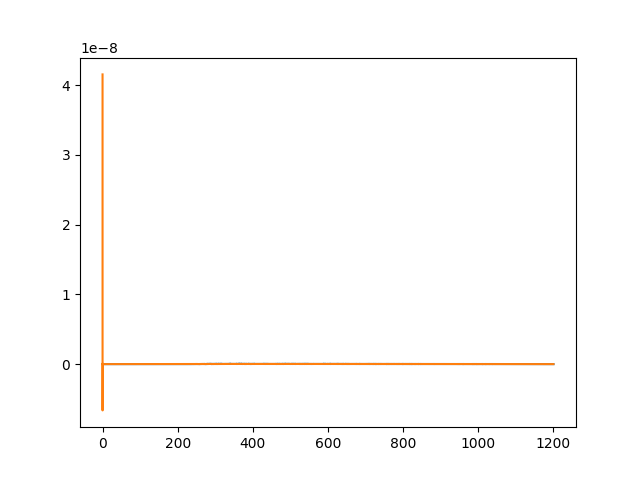

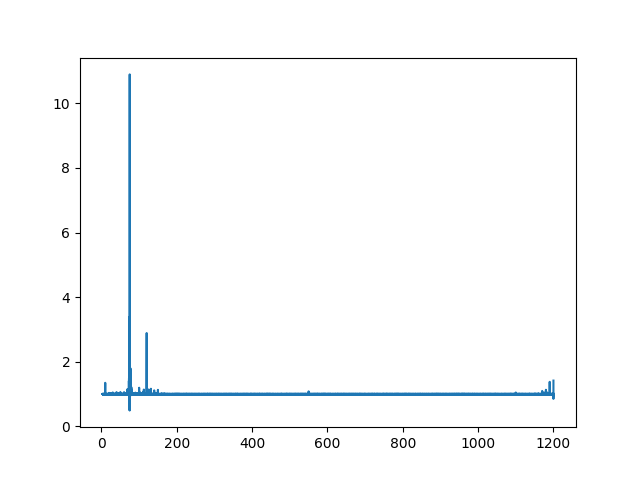

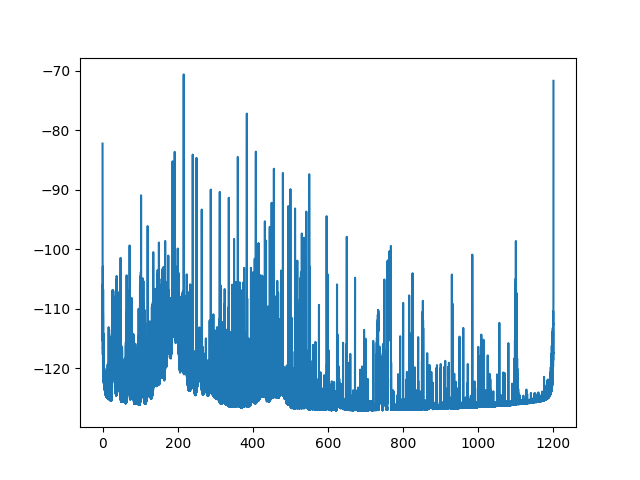

In [5]:
freqs = np.linspace(0, 1200, 2**22)
spec = np.load('./data_gitignore/30minuteRun_4dBAtt_9_6_23.npy', allow_pickle = True).item()['chBSpec_W']
specVeto = np.load('./data_gitignore/30minuteRun_4dBAtt_9_6_23.npy', allow_pickle = True).item()['chASpec_W']

#analysis params
medFiltBins = 51
butterFreq  = 12000
butterOrder = 6
startFreq   = 400    # MHz
stopFreq    = 700   # MHz
percent     = 50    # matched filter
overlap     = 100   # matched filter, bins
CL          = 0.95  # confidence limit

# Fit H to spec
#medianFilt = median_filt(spec, filter_size=medFiltBins)
H = (butter_filt(spec, cutoff = butterFreq, order = butterOrder))

#Norm spec: mean = 1, STD = 1
normSpec    = spec / H

plt.close('all')

plt.figure()
plt.plot(freqs[:-100], spec[1:-100])
plt.plot(freqs[:-100], H[1:-100])



plt.figure()
plt.plot(freqs[10000:-100],normSpec[10001:-100])

plt.figure()
plt.plot(freqs, 10*np.log10(specVeto[1:]*1000))

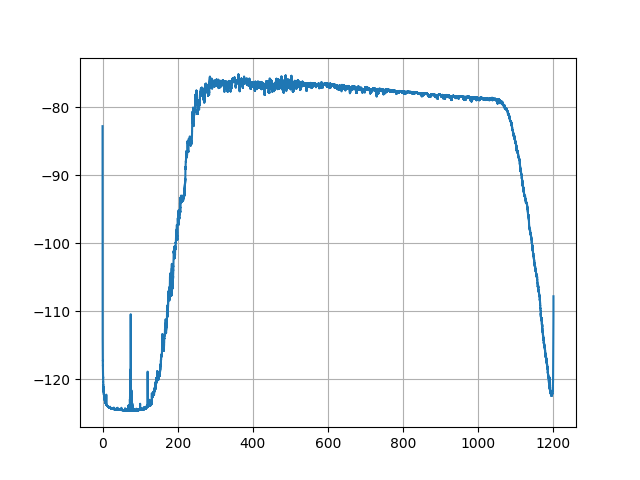

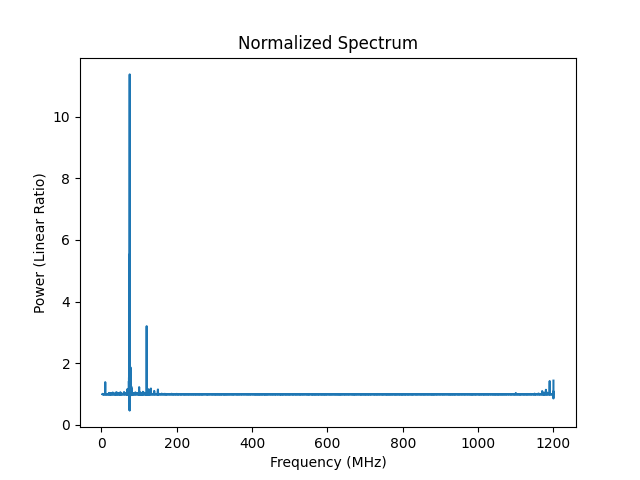

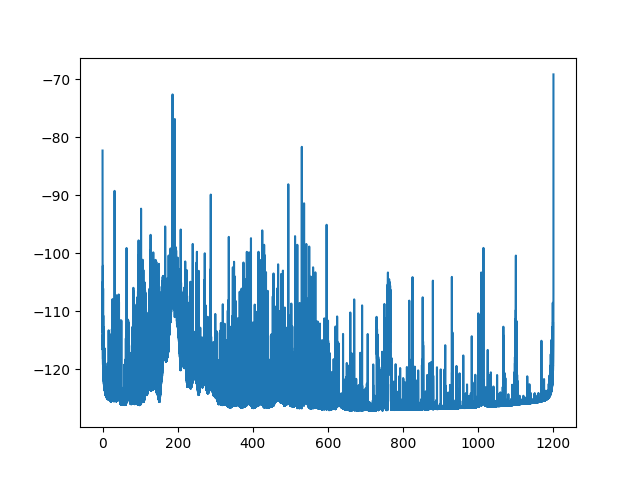

In [6]:
freqs = np.linspace(0, 1200, 2**22)
fileName        = '12hrRun_4dBatt_9_6_23.npy'
spec = np.load('./data_gitignore/' + fileName, allow_pickle = True).item()['chBSpec_W']
specVeto = np.load('./data_gitignore/' + fileName, allow_pickle = True).item()['chASpec_W']

#analysis params
medFiltBins = 51
butterFreq  = 12000
butterOrder = 6
startFreq   = 400    # MHz
stopFreq    = 700   # MHz
percent     = 50    # matched filter
overlap     = 100   # matched filter, bins
CL          = 0.95  # confidence limit

# Fit H to spec
#medianFilt = median_filt(spec, filter_size=medFiltBins)
H = (butter_filt(spec, cutoff = butterFreq, order = butterOrder))

#Norm spec: mean = 1, STD = 1
normSpec    = spec / H

plt.close('all')

plt.figure()
plt.plot(freqs[:-100], 10*np.log10(1000*spec[1:-100]))
#plt.plot(freqs[:-100], H[1:-100])
plt.grid(True)


plt.figure()
plt.title('Normalized Spectrum')
plt.plot(freqs[10000:-100],normSpec[10001:-100])
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (Linear Ratio)')

plt.figure()
plt.plot(freqs, 10*np.log10(specVeto[1:]*1000))

"\nprint(f'mean 1: {spec1.mean()}')\nprint(f'mean 2: {spec2.mean()}')\nprint(f'mean 3: {spec3.mean()}')\nprint(f'mean 4: {spec4.mean()}')\nprint(f'mean 5: {spec5.mean()}')\nprint(f'mean 6: {spec6.mean()}')\nprint(f'mean 7: {spec7.mean()}')\nprint(f'mean 8: {spec8.mean()}')\nprint(f'mean 9: {spec9.mean()}')\nprint(f'mean 10: {spec10.mean()}')\nprint(f'mean 11: {spec11.mean()}')\nprint(f'mean 12: {spec12.mean()}')\nprint(f'mean 13: {spec13.mean()}')\nprint(f'mean 14: {spec14.mean()}')\nprint(f'mean 15: {spec15.mean()}')\nprint(f'mean 16: {spec16.mean()}')\nprint(f'mean 17: {spec17.mean()}')"

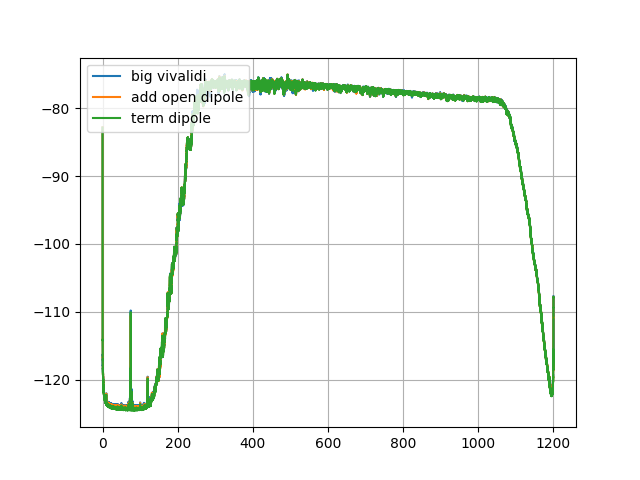

In [46]:
freqs = np.linspace(0, 1200, 2**22)

#scan
fileName        = 'antSpec1.npy'
spec1 = np.load('./data_gitignore/' + fileName, allow_pickle = True).item()['chBSpec_W']

#bump dipole antenna 1/4 inch
fileName        = 'antSpec2.npy'
spec2 = np.load('./data_gitignore/' + fileName, allow_pickle = True).item()['chBSpec_W']

#open and close door
fileName        = 'antSpec3.npy'
spec3 = np.load('./data_gitignore/' + fileName, allow_pickle = True).item()['chBSpec_W']

#turn attenuator from 0 to 30dB
fileName        = 'antSpec4.npy'
spec4 = np.load('./data_gitignore/' + fileName, allow_pickle = True).item()['chBSpec_W']

# put pcb vivaldi on box
fileName        = 'antSpec5.npy'
spec5 = np.load('./data_gitignore/' + fileName, allow_pickle = True).item()['chBSpec_W']

# terminate vivaldi
fileName        = 'antSpec6.npy'
spec6 = np.load('./data_gitignore/' + fileName, allow_pickle = True).item()['chBSpec_W']

# touch vivaldi
fileName        = 'antSpec7.npy'
spec7 = np.load('./data_gitignore/' + fileName, allow_pickle = True).item()['chBSpec_W']

# bump vivaldi ~1mm (for real, as small as I could)
fileName        = 'antSpec8.npy'
spec8 = np.load('./data_gitignore/' + fileName, allow_pickle = True).item()['chBSpec_W']

# termanator off vivaldi, didn't move
fileName        = 'antSpec9.npy'
spec9 = np.load('./data_gitignore/' + fileName, allow_pickle = True).item()['chBSpec_W']

# put pcb vivaldi behind big vivaldi facing away. Terminator off
fileName        = 'antSpec10.npy'
spec10 = np.load('./data_gitignore/' + fileName, allow_pickle = True).item()['chBSpec_W']

# Terminate vivaldi
fileName        = 'antSpec11.npy'
spec11 = np.load('./data_gitignore/' + fileName, allow_pickle = True).item()['chBSpec_W']

# switch to bicon
fileName        = 'antSpec12.npy'
spec12 = np.load('./data_gitignore/' + fileName, allow_pickle = True).item()['chBSpec_W']

#yagi
fileName        = 'antSpec13.npy'
spec13 = np.load('./data_gitignore/' + fileName, allow_pickle = True).item()['chBSpec_W']

#terminator
fileName        = 'antSpec14.npy'
spec14 = np.load('./data_gitignore/' + fileName, allow_pickle = True).item()['chBSpec_W']

#open
fileName        = 'antSpec15.npy'
spec15 = np.load('./data_gitignore/' + fileName, allow_pickle = True).item()['chBSpec_W']

#short
fileName        = 'antSpec16.npy'
spec16 = np.load('./data_gitignore/' + fileName, allow_pickle = True).item()['chBSpec_W']

#term into 470MHz LPF
fileName        = 'antSpec17.npy'
spec17 = np.load('./data_gitignore/' + fileName, allow_pickle = True).item()['chBSpec_W']

#short into double turn around (basically ~1 inch cable)
fileName        = 'antSpec18.npy'
spec18 = np.load('./data_gitignore/' + fileName, allow_pickle = True).item()['chBSpec_W']

#open into double turn around (basically ~1 inch cable)
fileName        = 'antSpec19.npy'
spec19 = np.load('./data_gitignore/' + fileName, allow_pickle = True).item()['chBSpec_W']

### Doesnt seem like the turnaround matters much

# term into 470MHz LPF into 1dB attenuator
fileName        = 'antSpec20.npy'
spec20 = np.load('./data_gitignore/' + fileName, allow_pickle = True).item()['chBSpec_W']

# term into 470MHz LPF into 2 * 1dB attenuator
fileName        = 'antSpec21.npy'
spec21 = np.load('./data_gitignore/' + fileName, allow_pickle = True).item()['chBSpec_W']

### 9/8/23

# big vivaldi
fileName        = 'antSpec22.npy'
spec22 = np.load('./data_gitignore/' + fileName, allow_pickle = True).item()['chBSpec_W']

# put open 50cm (total) dipole about 2 ft in front of vivaldi 
fileName        = 'antSpec23.npy'
spec23 = np.load('./data_gitignore/' + fileName, allow_pickle = True).item()['chBSpec_W']

# terminate dipole
fileName        = 'antSpec24.npy'
spec24 = np.load('./data_gitignore/' + fileName, allow_pickle = True).item()['chBSpec_W']


plt.close('all')
plt.figure()
#plt.plot(freqs[:-100], 10*np.log10(1000*spec1[1:-100]), label = 'nothing')
#plt.plot(freqs[:-100], 10*np.log10(1000*spec2[1:-100]), label = 'bump dipole')
#plt.plot(freqs[:-100], 10*np.log10(1000*spec3[1:-100]), label = 'open close door')
#plt.plot(freqs[:-100], 10*np.log10(1000*spec4[1:-100]), label = 'turn attenuator')
#plt.plot(freqs[:-100], 10*np.log10(1000*spec5[1:-100]), label = 'open vivaldi')
#plt.plot(freqs[:-100], 10*np.log10(1000*spec6[1:-100]), label = 'term vivaldi')
#plt.plot(freqs[:-100], 10*np.log10(1000*spec7[1:-100]), label = 'touch vivaldi')
#plt.plot(freqs[:-100], 10*np.log10(1000*spec8[1:-100]), label = 'bump vivaldi')
#plt.plot(freqs[:-100], 10*np.log10(1000*spec9[1:-100]), label = 'term off vivaldi')
#plt.plot(freqs[:-100], 10*np.log10(1000*spec10[1:-100]), label = 'vivaldi behind')
#plt.plot(freqs[:-100], 10*np.log10(1000*spec11[1:-100]), label = 'terminate vivaldi')
#plt.plot(freqs[:-100], 10*np.log10(1000*spec12[1:-100]), label = 'bicon')
#plt.plot(freqs[:-100], 10*np.log10(1000*spec13[1:-100]), label = 'yagi')
#plt.plot(freqs[:-100], 10*np.log10(1000*spec14[1:-100]), label = 'term')
#plt.plot(freqs[:-100], 10*np.log10(1000*spec15[1:-100]), label = 'open')
#plt.plot(freqs[:-100], 10*np.log10(1000*spec16[1:-100]), label = 'short')
#plt.plot(freqs[:-100], 10*np.log10(1000*spec17[1:-100]), label = 'term+LPF')
#plt.plot(freqs[:-100], 10*np.log10(1000*spec18[1:-100]), label = 'short+turnaround')
#plt.plot(freqs[:-100], 10*np.log10(1000*spec19[1:-100]), label = 'open+turnaround')
#plt.plot(freqs[:-100], 10*np.log10(1000*spec20[1:-100]), label = 'term+LPF+1dB att')
#plt.plot(freqs[:-100], 10*np.log10(1000*spec21[1:-100]), label = 'term+LPF+2dB att')
plt.plot(freqs[:-100], 10*np.log10(1000*spec22[1:-100]), label = 'big vivalidi')
plt.plot(freqs[:-100], 10*np.log10(1000*spec23[1:-100]), label = 'add open dipole')
plt.plot(freqs[:-100], 10*np.log10(1000*spec24[1:-100]), label = 'term dipole')


plt.grid(True)
plt.legend(loc='upper left')
'''
print(f'mean 1: {spec1.mean()}')
print(f'mean 2: {spec2.mean()}')
print(f'mean 3: {spec3.mean()}')
print(f'mean 4: {spec4.mean()}')
print(f'mean 5: {spec5.mean()}')
print(f'mean 6: {spec6.mean()}')
print(f'mean 7: {spec7.mean()}')
print(f'mean 8: {spec8.mean()}')
print(f'mean 9: {spec9.mean()}')
print(f'mean 10: {spec10.mean()}')
print(f'mean 11: {spec11.mean()}')
print(f'mean 12: {spec12.mean()}')
print(f'mean 13: {spec13.mean()}')
print(f'mean 14: {spec14.mean()}')
print(f'mean 15: {spec15.mean()}')
print(f'mean 16: {spec16.mean()}')
print(f'mean 17: {spec17.mean()}')'''